# Imports

In [87]:
import sys
import optuna
import mlflow
import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import mlflow.sklearn
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold


sys.path.insert(1, '../scripts')
from silhouette_score import get_silhouette_score

optuna.logging.set_verbosity(optuna.logging.WARNING)

# Gerando as funções de treinamento

In [37]:
def train_linear_regression(df_train: pd.DataFrame, df_val: pd.DataFrame, test_name: str) -> None:
    print(f"LINEAR REGRESSION: {test_name:^20}")

    X_train, y_train = df_train.drop(columns=["Next Week's Deaths"]), df_train["Next Week's Deaths"]
    X_val, y_val = df_val.drop(columns=["Next Week's Deaths"]), df_val["Next Week's Deaths"]

    LinearRegressionParams = {
        "fit_intercept": [True, False],
        "copy_X": [True, False]
    }

    def objective(trial):
        model_params = {key: trial.suggest_categorical(key, values) for key, values in LinearRegressionParams.items()}

        with mlflow.start_run():
            model = LinearRegression(**model_params, n_jobs=-1)
            model.fit(X_train, y_train)

            y_pred = model.predict(X_val)
            mse = mean_squared_error(y_val, y_pred)

            for key, value in model_params.items():
                mlflow.log_param(key, value)

            mlflow.log_metric('mse', mse)
            mlflow.sklearn.log_model(model, 'model')
            return mse

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)

    print('Melhores hiperparâmetros:', study.best_params)
    print('Melhor valor objetivo:', study.best_value)

    study.trials_dataframe().to_csv(f'../data/LinearRegressionParams_{test_name}_study.csv')

In [38]:
def train_ridge(df_train: pd.DataFrame, df_val: pd.DataFrame, test_name: str) -> None:
    print(f"RIDGE: {test_name:^20}")

    X_train, y_train = df_train.drop(columns=["Next Week's Deaths"]), df_train["Next Week's Deaths"]
    X_val, y_val = df_val.drop(columns=["Next Week's Deaths"]), df_val["Next Week's Deaths"]

    RidgeRegressionParams = {
        "alpha": [0.001, 0.01, 0.1, 0.5, 1, 5, 10, 100, 1000],
        "fit_intercept": [True, False],
        "copy_X": [True, False],
        "solver": ["auto", "svd", "cholesky", "lsqr", "sparse_cg", "sag", "saga"]
    }

    def objective(trial):
        model_params = {key: trial.suggest_categorical(key, values) for key, values in RidgeRegressionParams.items()}

        with mlflow.start_run():
            model = Ridge(**model_params, random_state=42)
            model.fit(X_train, y_train)

            y_pred = model.predict(X_val)
            mse = mean_squared_error(y_val, y_pred)

            for key, value in model_params.items():
                mlflow.log_param(key, value)

            mlflow.log_metric('mse', mse)
            mlflow.sklearn.log_model(model, 'model')

            return mse

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)

    print('Melhores hiperparâmetros:', study.best_params)
    print('Melhor valor objetivo:', study.best_value)

    study.trials_dataframe().to_csv(f'../data/Ridge_{test_name}_study.csv')

In [39]:
def train_SVR(df_train: pd.DataFrame, df_val: pd.DataFrame, test_name: str) -> None:
    print(f"SVR: {test_name:^20}")

    X_train, y_train = df_train.drop(columns=["Next Week's Deaths"]), df_train["Next Week's Deaths"]
    X_val, y_val = df_val.drop(columns=["Next Week's Deaths"]), df_val["Next Week's Deaths"]

    SVRParams = {
        "C": [0.01, 0.1, 1, 10, 100],
        "kernel": ["linear", "rbf"],
        "degree": [2, 3, 5],
        "gamma": ["scale", "auto"],
        "coef0": [0.0, 0.5, 1.0, 5.0]
    }

    def objective(trial):
        model_params = {key: trial.suggest_categorical(key, values) for key, values in SVRParams.items()}

        with mlflow.start_run():
            # Limitando pois é um treinamento demorado
            model = SVR(**model_params, max_iter=500)
            model.fit(X_train, y_train)

            y_pred = model.predict(X_val)
            mse = mean_squared_error(y_val, y_pred)

            for key, value in model_params.items():
                mlflow.log_param(key, value)

            mlflow.log_metric('mse', mse)
            mlflow.sklearn.log_model(model, 'model')
            return mse

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)

    print('Melhores hiperparâmetros:', study.best_params)
    print('Melhor valor objetivo:', study.best_value)

    study.trials_dataframe().to_csv(f'../data/SVR_{test_name}_study.csv')

In [40]:
def train_RandomForestRegressor(df_train: pd.DataFrame, df_val: pd.DataFrame, test_name: str) -> None:
    print(f"RANDOM FOREST: {test_name:^20}")

    X_train, y_train = df_train.drop(columns=["Next Week's Deaths"]), df_train["Next Week's Deaths"]
    X_val, y_val = df_val.drop(columns=["Next Week's Deaths"]), df_val["Next Week's Deaths"]

    RandomForestRegressorParams = {
        "n_estimators": [10, 50, 100, 200, 500],
        "max_depth": [None, 5, 10, 20, 50],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "max_features": ["sqrt", "log2"],
        "bootstrap": [True, False]
    }

    def objective(trial):
        model_params = {key: trial.suggest_categorical(key, values) for key, values in RandomForestRegressorParams.items()}

        with mlflow.start_run():
            model = RandomForestRegressor(**model_params, n_jobs=-1, random_state=42)
            model.fit(X_train, y_train)

            # Fazer previsões e calcular o erro quadrático médio
            y_pred = model.predict(X_val)
            mse = mean_squared_error(y_val, y_pred)

            # Registrar os parâmetros e métricas no MLflow
            for key, value in model_params.items():
                mlflow.log_param(key, value)

            mlflow.log_metric('mse', mse)
            mlflow.sklearn.log_model(model, 'model')
            return mse

    # Configurar e executar a otimização do Optuna
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)

    print('Melhores hiperparâmetros:', study.best_params)
    print('Melhor valor objetivo:', study.best_value)

    study.trials_dataframe().to_csv(f'../data/RandomForestRegressor_{test_name}_study.csv')

# Treinando

In [41]:
datasets = [
    "df_preprocessed_normalized"
]

In [ ]:
for dataset in datasets:
    for i in ["train", "val"]:
        df = pd.read_csv(f"../data/{dataset}_{i}.csv")
        if i == "train":
            df_train = df
        elif i == "val":
            df_val = df
    train_linear_regression(df_train, df_val, dataset)
    train_ridge(df_train, df_val, dataset)
    if "normalized" in dataset:
        train_SVR(df_train, df_val, dataset)
    train_RandomForestRegressor(df_train, df_val, dataset)

O melhor modelo de cada algorítmo foi:

 - Linear regression:
    - Melhores hiperparâmetros: {'fit_intercept': False, 'copy_X': True}
    - Melhor valor objetivo: 0.01425178903182007
 - Ridge:
    - Melhores hiperparâmetros: {'alpha': 0.001, 'fit_intercept': False, 'copy_X': False, 'solver': 'svd'}
    - Melhor valor objetivo: 0.014251772276254182
 - SVR:
    - Melhores hiperparâmetros: {'C': 1, 'kernel': 'rbf', 'degree': 5, 'gamma': 'auto', 'coef0': 1.0}
    - Melhor valor objetivo: 0.08873104452480272
 - Random Forest:
    - Melhores hiperparâmetros: {'n_estimators': 500, 'max_depth': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': False}
    - Melhor valor objetivo: 0.0025254398854317383

# Scatter plot com clustering

In [23]:
df_train = pd.read_csv("../data/df_preprocessed_normalized_train.csv")
df_test = pd.read_csv("../data/df_preprocessed_normalized_test.csv")
df_val = pd.read_csv("../data/df_preprocessed_normalized_val.csv")

In [9]:
len(df_train.columns)

30

In [10]:
df = df_train.copy()

In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75841 entries, 0 to 75840
Data columns (total 30 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Weekly Cases                         75841 non-null  float64
 1   Year                                 75841 non-null  float64
 2   Weekly Cases per Million             75841 non-null  float64
 3   Weekly Deaths                        75841 non-null  float64
 4   Weekly Deaths per Million            75841 non-null  float64
 5   Next Week's Deaths                   75841 non-null  float64
 6   Total Vaccinations                   75841 non-null  float64
 7   People Vaccinated                    75841 non-null  float64
 8   People Fully Vaccinated              75841 non-null  float64
 9   Total Boosters                       75841 non-null  float64
 10  Daily Vaccinations                   75841 non-null  float64
 11  Total Vaccinations per Hundr

For n_clusters = 2 The average silhouette_score is : 0.7747379531695581
For n_clusters = 3 The average silhouette_score is : 0.34093610657445494
For n_clusters = 4 The average silhouette_score is : 0.2084377475889072
For n_clusters = 5 The average silhouette_score is : 0.2527171786120726
For n_clusters = 6 The average silhouette_score is : 0.2530090878804421


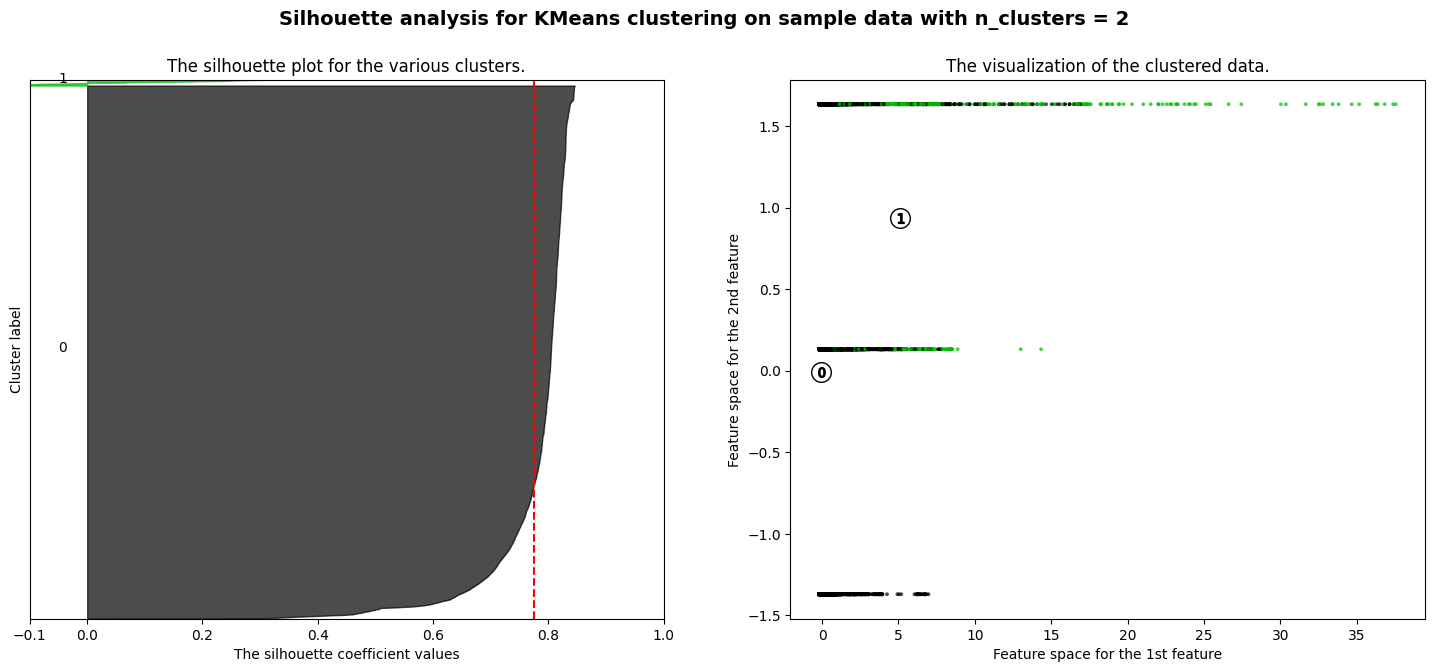

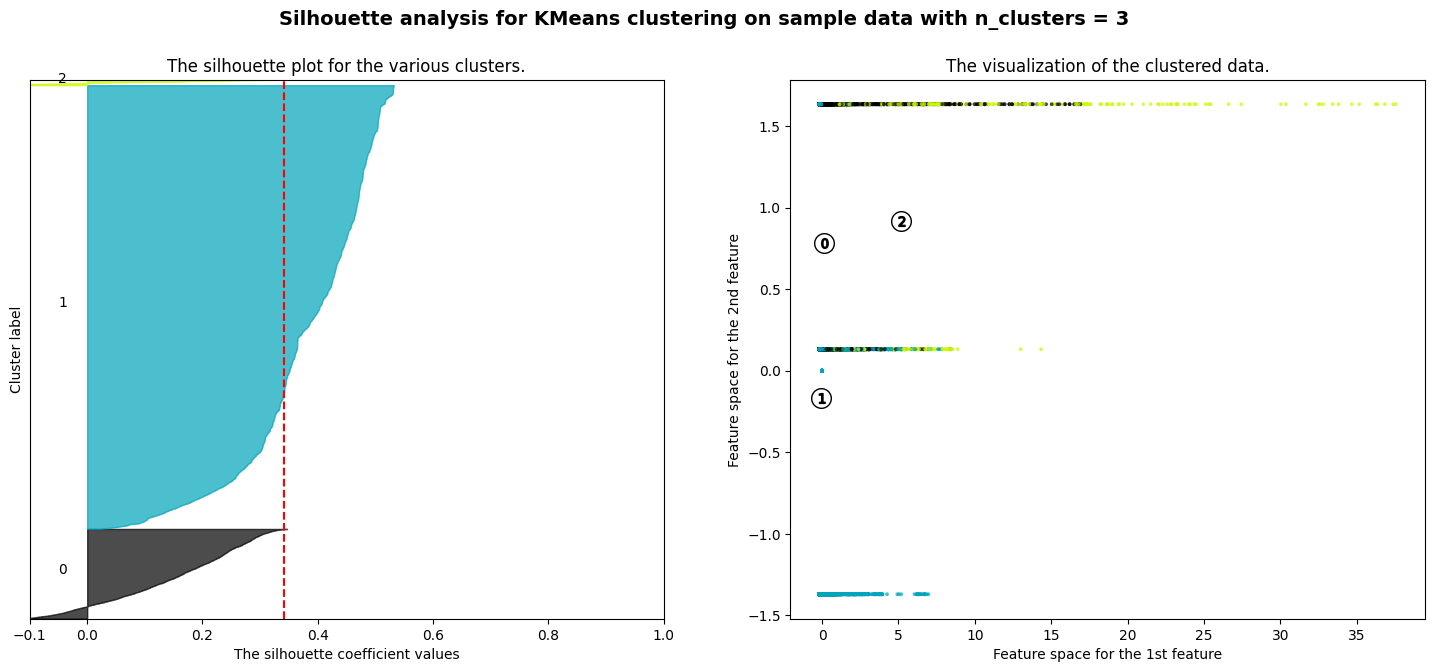

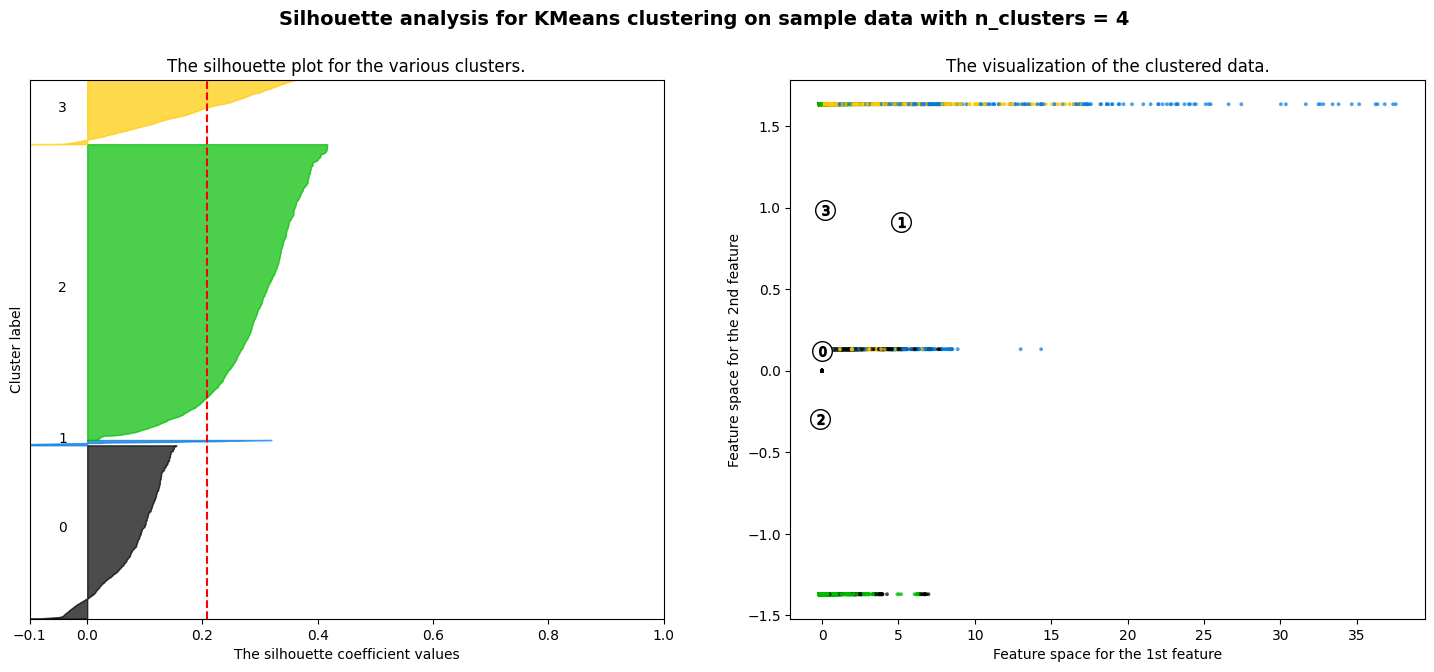

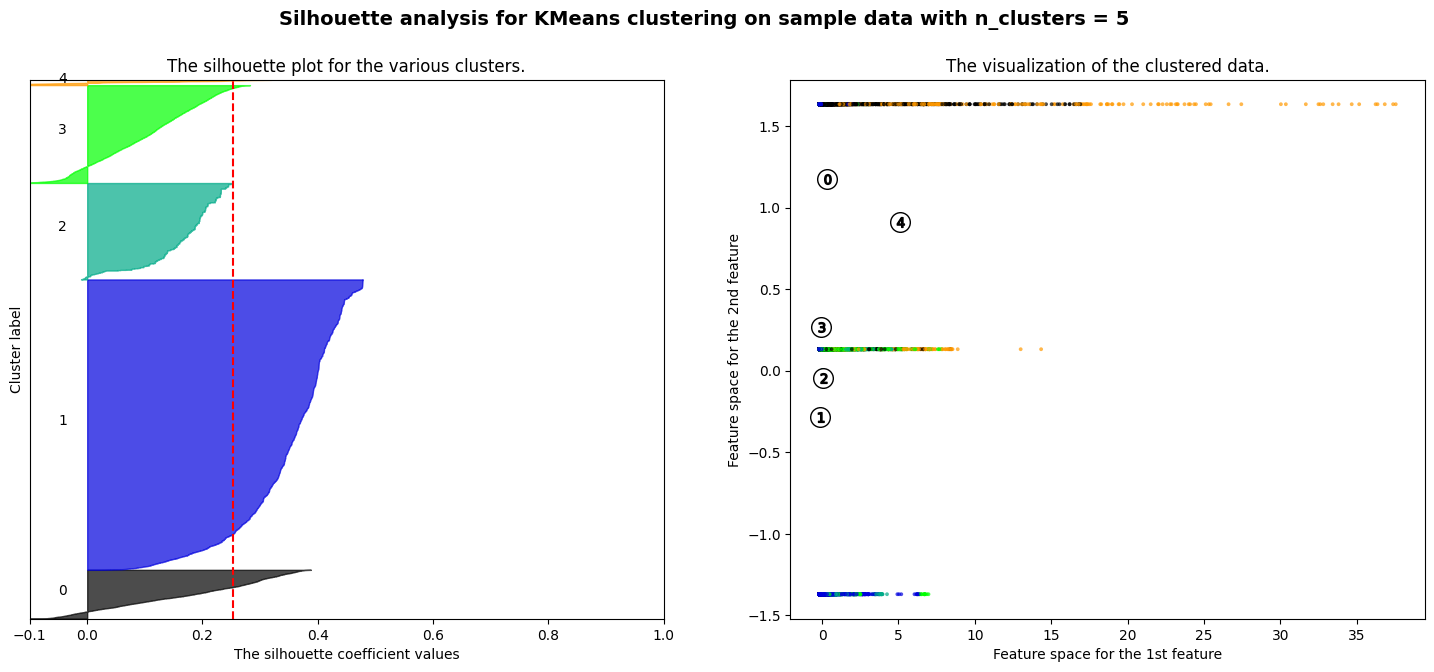

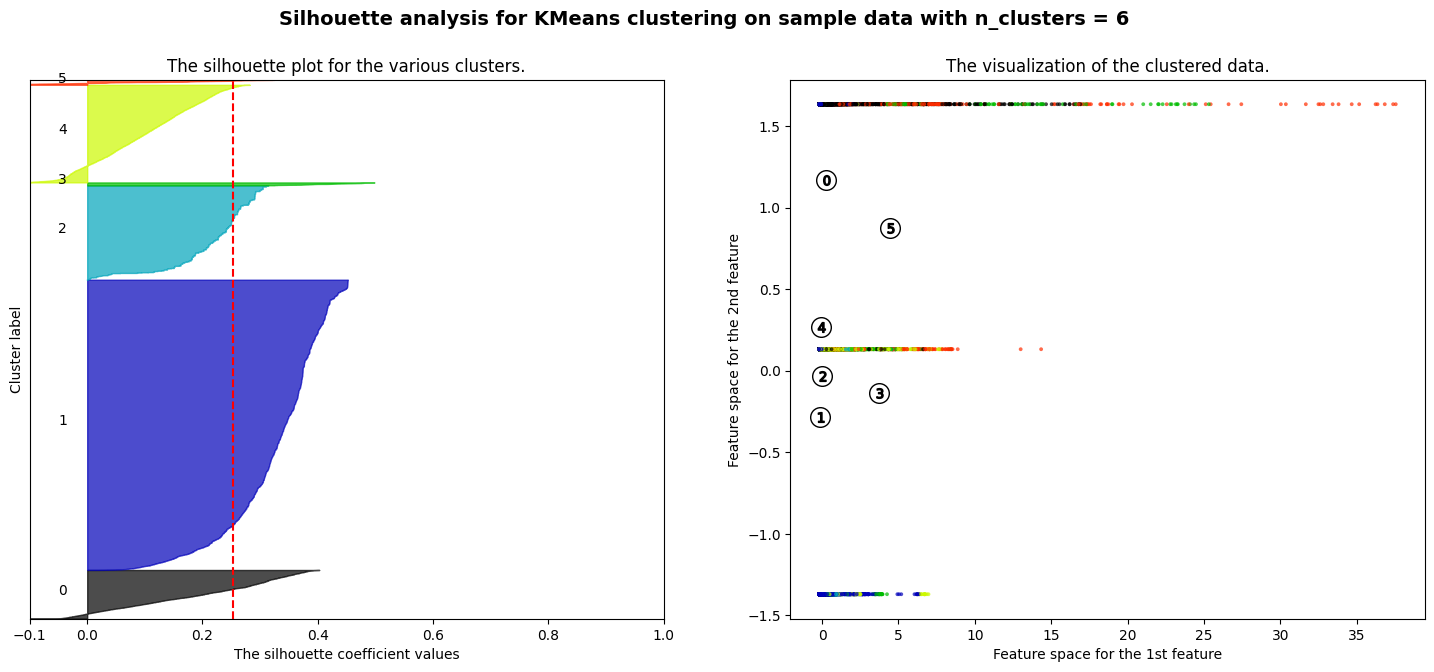

In [12]:
get_silhouette_score(df_train.drop(columns=["Next Week's Deaths"]).values, [2, 3, 4, 5, 6])

O melhor score é quando k = 2

In [13]:
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(df.drop(columns=["Next Week's Deaths"]))
df["cluster"] = clusters

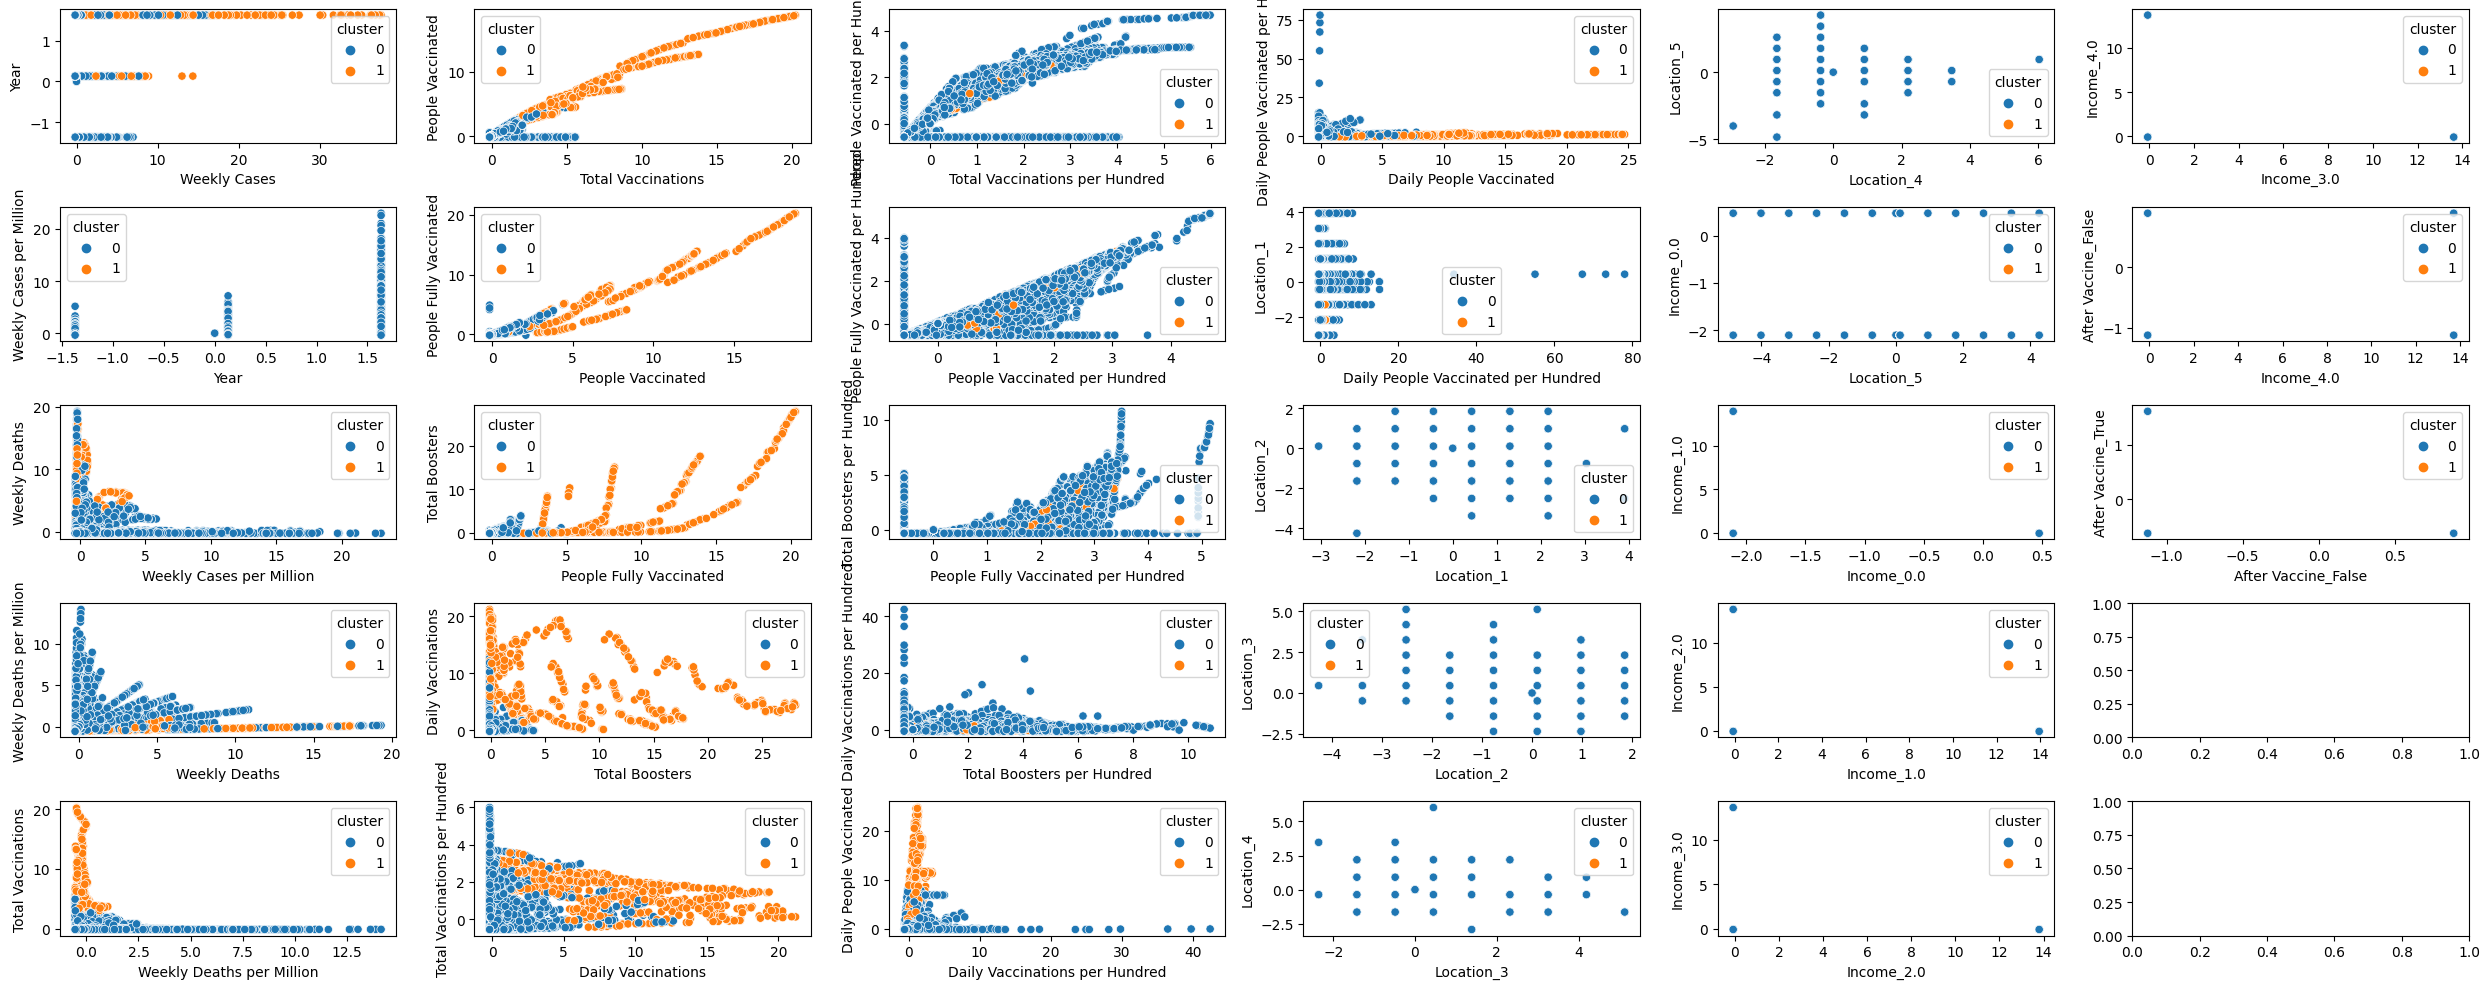

In [14]:
figs, axes = plt.subplots(5,6,figsize=(25,10))
i, j = 0, 0
cols = df_train.drop(columns=["Next Week's Deaths"]).columns
for idx in range(len(cols)-1):
    sns.scatterplot(data=df, x=cols[idx], y=cols[idx + 1], hue='cluster', ax=axes[i, j])
    i+=1
    if i == 5:
        i = 0
        j+=1
plt.tight_layout()

IndexError: index 5 is out of bounds for axis 1 with size 5

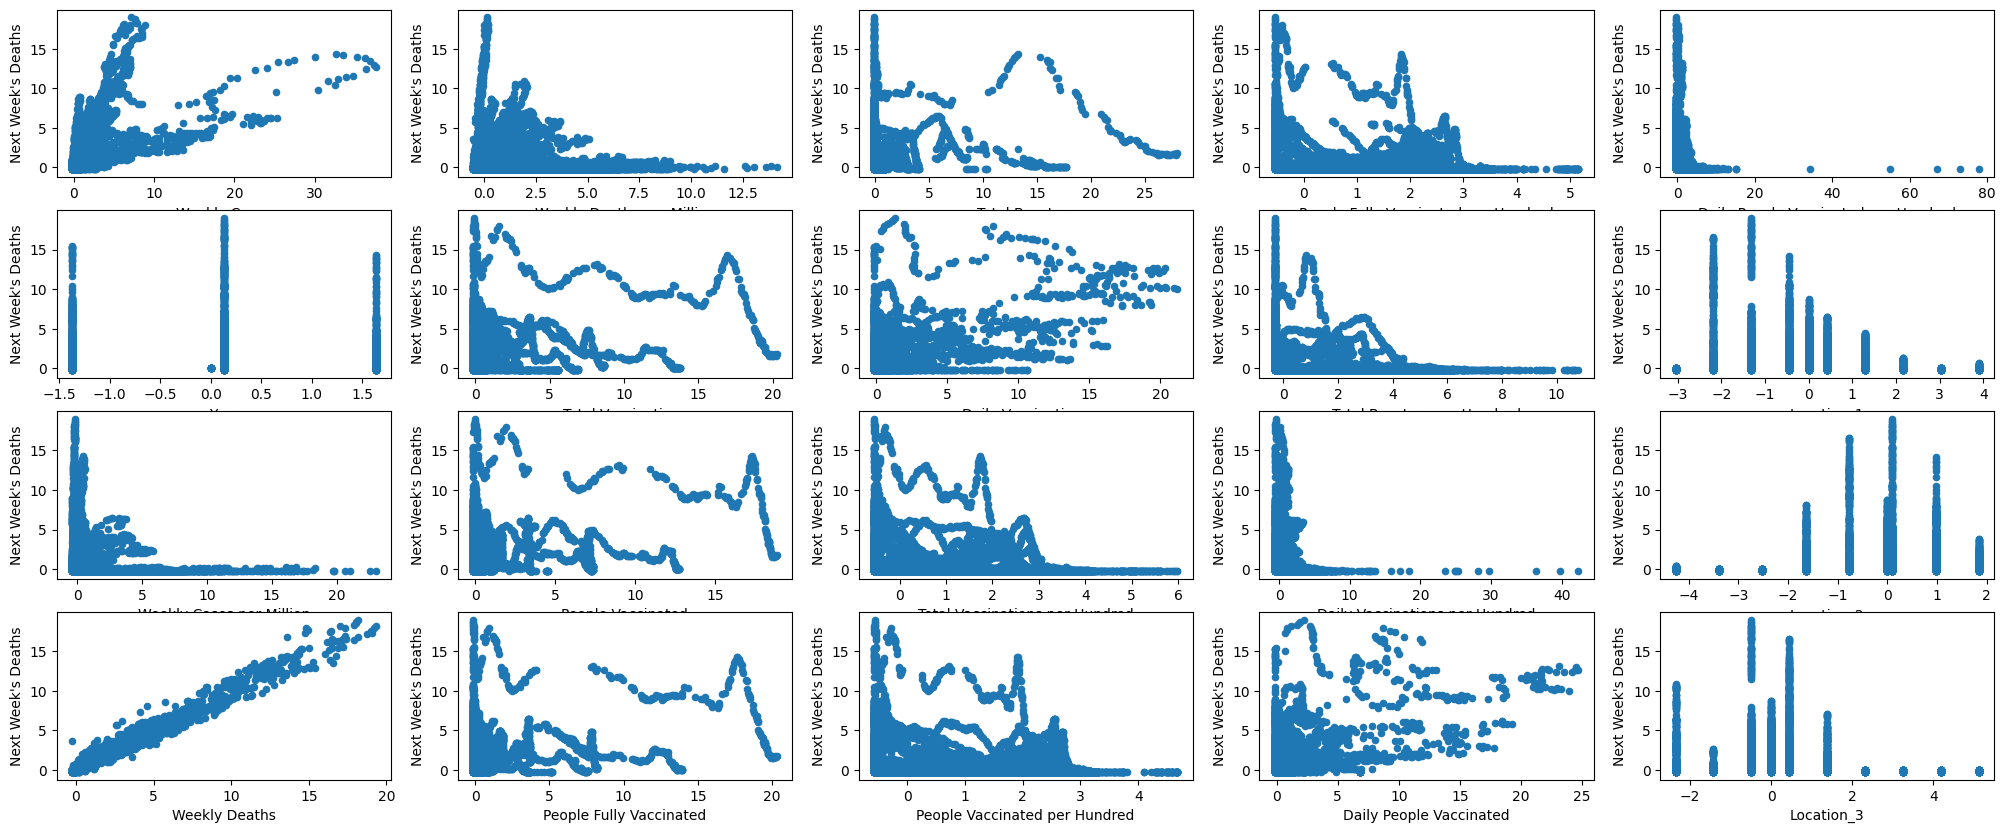

In [15]:
figs, axes = plt.subplots(4,5,figsize=(25,10))
i, j = 0, 0
for col in df_train.drop(columns=["Next Week's Deaths"]).columns:
    df_train[[col, "Next Week's Deaths"]].plot.scatter(x=col, y="Next Week's Deaths", ax=axes[i, j])
    i+=1
    if i == 4:
        i = 0
        j+=1
plt.tight_layout()

# Escolhendo o Melhor modelo pelo conjunto de teste

In [24]:
X_train, y_train = df_train.drop(columns=["Next Week's Deaths"]), df_train["Next Week's Deaths"]
X_test, y_test = df_test.drop(columns=["Next Week's Deaths"]), df_test["Next Week's Deaths"]
X_val, y_val = df_val.drop(columns=["Next Week's Deaths"]), df_val["Next Week's Deaths"]

### Linear Regression

In [64]:
lr_model = LinearRegression(**{'fit_intercept': False, 'copy_X': True}, n_jobs=-1)
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_val)

print("----- VAL -----")
print("R2:      {:.3f}".format(r2_score(y_val, y_pred)))
print("MSE:     {:.3f}".format(mean_squared_error(y_val, y_pred)))
print("MAE:    {:.3f}".format(mean_absolute_error(y_val, y_pred)))

y_pred_test = lr_model.predict(X_test)

print("----- TEST -----")
print("R2:      {:.3f}".format(r2_score(y_test, y_pred_test)))
print("MSE:     {:.3f}".format(mean_squared_error(y_test, y_pred_test)))
print("MAE:    {:.3f}".format(mean_absolute_error(y_test, y_pred_test)))

----- VAL -----
R2:      0.986
MSE:     0.014
MAE:    0.029
----- TEST -----
R2:      0.985
MSE:     0.014
MAE:    0.028


O erro no treinamento do Linear Regression foi muito próximo nos entre os conjuntos de teste e validação, o que sugere uma baixa variância. Além nisso, o erro é baixo, o que sugere que é um bom modelo para resolver o nosso problema.

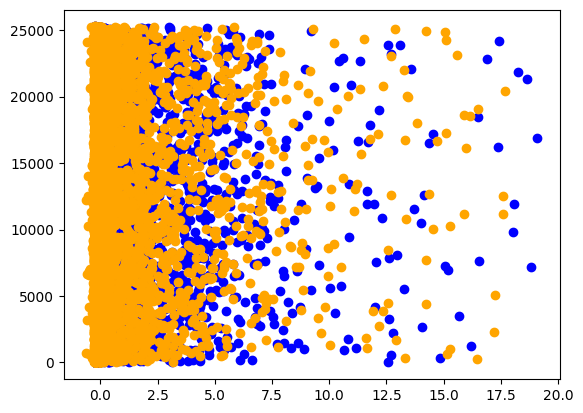

In [70]:
plt.scatter(y_test, range(len(y_test)), color='blue')
plt.scatter(y_pred, range(len(y_pred)), color='orange')
plt.show()

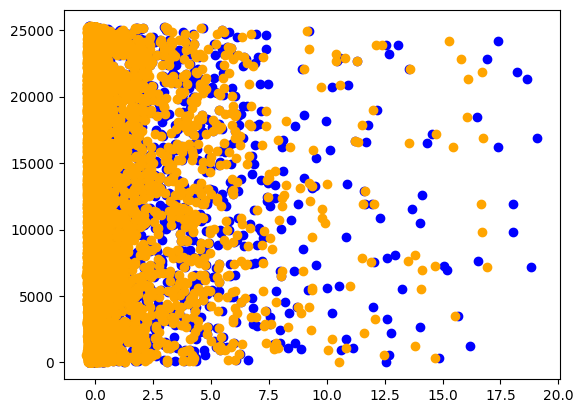

In [82]:
plt.scatter(y_test, range(len(y_test)), color='blue')
plt.scatter(y_pred_test, range(len(y_pred_test)), color='orange')
plt.show()

### Ridge

In [71]:
ridge_model = Ridge(**{'alpha': 0.001, 'fit_intercept': False, 'copy_X': False, 'solver': 'svd'}, random_state=42)
ridge_model.fit(X_train, y_train)

y_pred = ridge_model.predict(X_val)

print("----- VAL -----")
print("R2:      {:.3f}".format(r2_score(y_val, y_pred)))
print("MSE:     {:.3f}".format(mean_squared_error(y_val, y_pred)))
print("MAE:    {:.3f}".format(mean_absolute_error(y_val, y_pred)))

y_pred_test = ridge_model.predict(X_test)

print("----- TEST -----")
print("R2:      {:.3f}".format(r2_score(y_test, y_pred_test)))
print("MSE:     {:.3f}".format(mean_squared_error(y_test, y_pred_test)))
print("MAE:    {:.3f}".format(mean_absolute_error(y_test, y_pred_test)))

----- VAL -----
R2:      0.986
MSE:     0.014
MAE:    0.029
----- TEST -----
R2:      0.985
MSE:     0.014
MAE:    0.028


O erro no treinamento do Ridge foi muito próximo nos entre os conjuntos de teste e validação, o que sugere uma baixa variância. Além nisso, o erro é baixo, o que sugere que é um bom modelo para resolver o nosso problema.

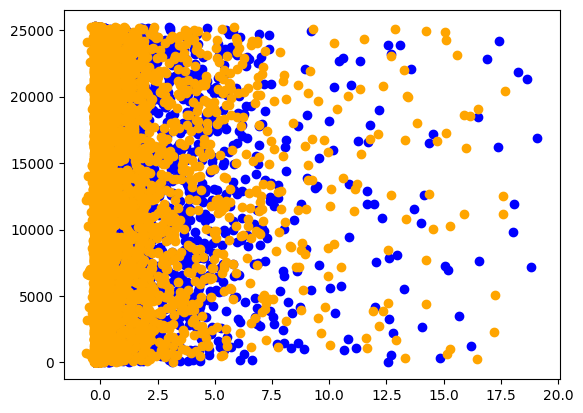

In [73]:
plt.scatter(y_test, range(len(y_test)), color='blue')
plt.scatter(y_pred, range(len(y_pred)), color='orange')
plt.show()

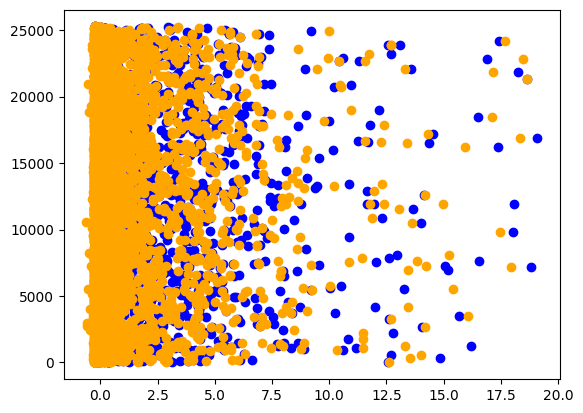

In [74]:
plt.scatter(y_test, range(len(y_test)), color='blue')
plt.scatter(y_pred_test, range(len(y_pred_test)), color='orange')
plt.show()

### SVR

In [75]:
svr_model = SVR(**{'C': 1, 'kernel': 'rbf', 'degree': 5, 'gamma': 'auto', 'coef0': 1.0})
svr_model.fit(X_train, y_train)

y_pred = svr_model.predict(X_val)

print("----- VAL -----")
print("R2:      {:.3f}".format(r2_score(y_val, y_pred)))
print("MSE:     {:.3f}".format(mean_squared_error(y_val, y_pred)))
print("MAE:    {:.3f}".format(mean_absolute_error(y_val, y_pred)))

y_pred_test = svr_model.predict(X_test)

print("----- TEST -----")
print("R2:      {:.3f}".format(r2_score(y_test, y_pred_test)))
print("MSE:     {:.3f}".format(mean_squared_error(y_test, y_pred_test)))
print("MAE:    {:.3f}".format(mean_absolute_error(y_test, y_pred_test)))

----- VAL -----
R2:      0.981
MSE:     0.020
MAE:    0.058
----- TEST -----
R2:      0.979
MSE:     0.021
MAE:    0.058


O erro no treinamento do SVR foi muito próximo nos entre os conjuntos de teste e validação, o que sugere uma baixa variância. Além nisso, o erro é baixo, o que sugere que é um bom modelo para resolver o nosso problema.

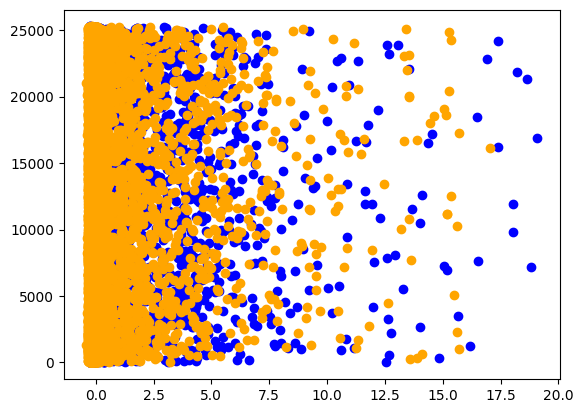

In [76]:
plt.scatter(y_test, range(len(y_test)), color='blue')
plt.scatter(y_pred, range(len(y_pred)), color='orange')
plt.show()

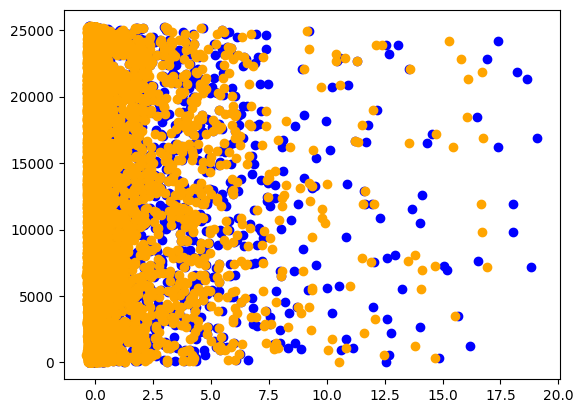

In [77]:
plt.scatter(y_test, range(len(y_test)), color='blue')
plt.scatter(y_pred_test, range(len(y_pred_test)), color='orange')
plt.show()

### Random Forest

In [78]:
rf_model = RandomForestRegressor(**{'n_estimators': 500, 'max_depth': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': False}, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_val)

print("----- VAL -----")
print("R2:      {:.3f}".format(r2_score(y_val, y_pred)))
print("MSE:     {:.3f}".format(mean_squared_error(y_val, y_pred)))
print("MAE:    {:.3f}".format(mean_absolute_error(y_val, y_pred)))

y_pred_test = svr_model.predict(X_test)

print("----- TEST -----")
print("R2:      {:.3f}".format(r2_score(y_test, y_pred_test)))
print("MSE:     {:.3f}".format(mean_squared_error(y_test, y_pred_test)))
print("MAE:    {:.3f}".format(mean_absolute_error(y_test, y_pred_test)))

----- VAL -----
R2:      0.998
MSE:     0.003
MAE:    0.009
----- TEST -----
R2:      0.979
MSE:     0.021
MAE:    0.058


O erro no treinamento do Random foi distante entre os conjuntos de teste e validação, o que sugere alta variância. Como o erro de teste foi muito baixo, o modelo passou por um caso de overfiting. Por isso, vamos descartar o RF e usar os outros modelos.

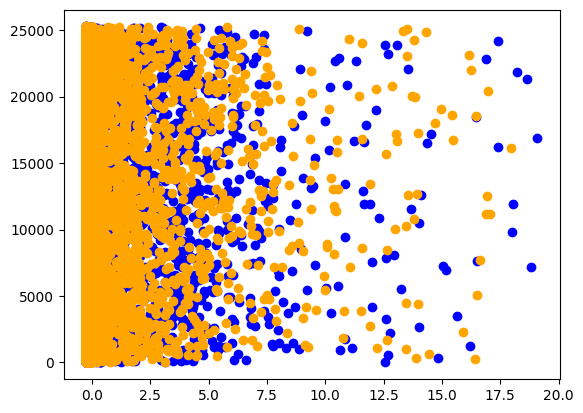

In [80]:
plt.scatter(y_test, range(len(y_test)), color='blue')
plt.scatter(y_pred, range(len(y_pred)), color='orange')
plt.show()

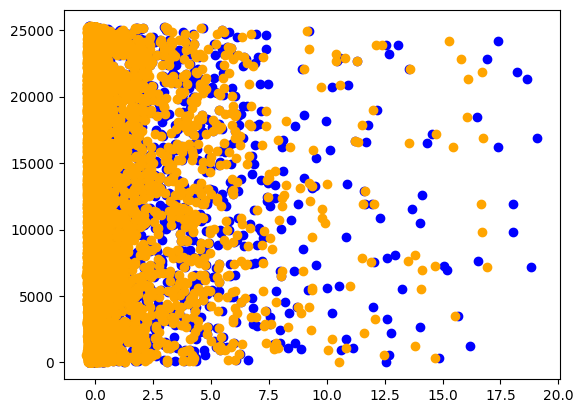

In [81]:
plt.scatter(y_test, range(len(y_test)), color='blue')
plt.scatter(y_pred_test, range(len(y_pred)), color='orange')
plt.show()

# Cross validation

In [83]:
def collect_errors(model, X, y, X_test, y_test):
    errors_val, errors_test = [], []
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        model.fit(X_train, y_train)

        y_pred = model.predict(X_val)
        mse = mean_squared_error(y_val, y_pred)
        errors_val.append(mse)

        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        errors_test.append(mse)

    return errors_val, errors_test

In [84]:
svr_model = SVR(**{'C': 1, 'kernel': 'rbf', 'degree': 5, 'gamma': 'auto', 'coef0': 1.0})
ridge_model = Ridge(**{'alpha': 0.001, 'fit_intercept': False, 'copy_X': False, 'solver': 'svd'}, random_state=42)
lr_model = LinearRegression(**{'fit_intercept': False, 'copy_X': True}, n_jobs=-1)

svr_errors_val, svr_errors_test = collect_errors(svr_model, np.concatenate([X_train, X_val]), np.concatenate([y_train,y_val]), X_test, y_test)
ridge_errors_val, ridge_errors_test = collect_errors(ridge_model, np.concatenate([X_train, X_val]), np.concatenate([y_train,y_val]), X_test, y_test)
lr_errors_val, lr_errors_test = collect_errors(lr_model, np.concatenate([X_train, X_val]), np.concatenate([y_train,y_val]), X_test, y_test)

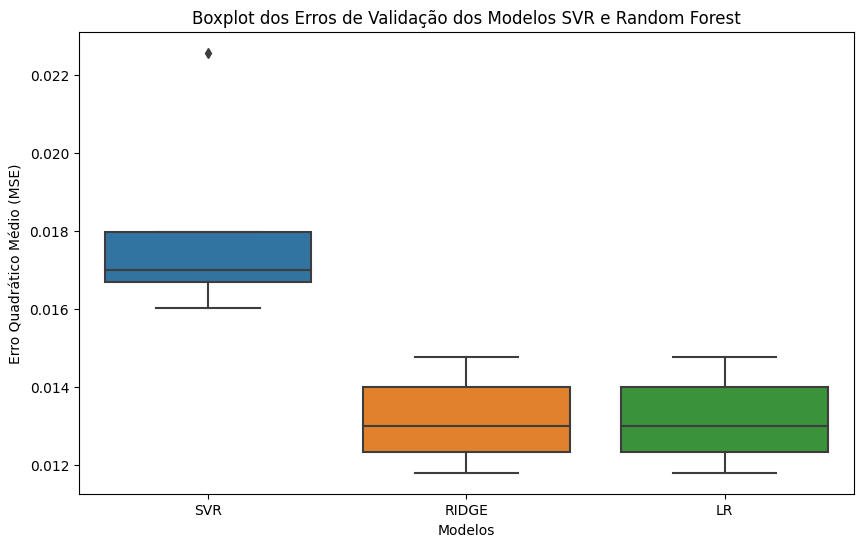

In [85]:
errors_df = pd.DataFrame({
    'SVR': svr_errors_val,
    'RIDGE': ridge_errors_val,
    'LR': lr_errors_val
})

plt.figure(figsize=(10, 6))
sns.boxplot(data=errors_df)
plt.title('Boxplot dos Erros de Validação dos Modelos SVR e Random Forest')
plt.ylabel('Erro Quadrático Médio (MSE)')
plt.xlabel('Modelos')
plt.show()

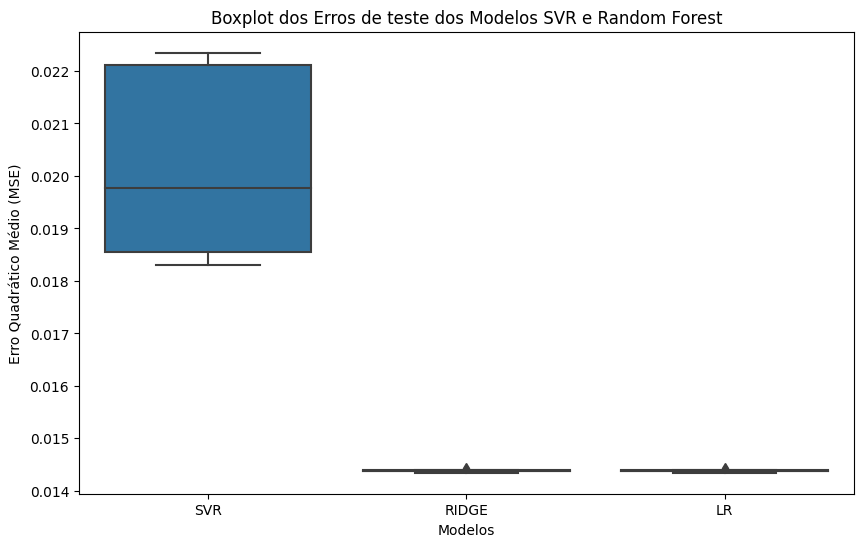

In [86]:
errors_df = pd.DataFrame({
    'SVR': svr_errors_test,
    'RIDGE': ridge_errors_test,
    'LR': lr_errors_test
})

plt.figure(figsize=(10, 6))
sns.boxplot(data=errors_df)
plt.title('Boxplot dos Erros de teste dos Modelos SVR e Random Forest')
plt.ylabel('Erro Quadrático Médio (MSE)')
plt.xlabel('Modelos')
plt.show()

#### Teste de Hipótese: o ridge e o linear regression são os melhores, mas o ridge e o linear regression têm performances semelhantes

In [88]:
# hipotese nula: distribuição normal
stats.shapiro(svr_errors_test), stats.shapiro(ridge_errors_test)

(ShapiroResult(statistic=0.8531018495559692, pvalue=0.20452356338500977),
 ShapiroResult(statistic=0.9696120023727417, pvalue=0.8727577328681946))

In [90]:
# hipotese nula: distribuição normal
stats.shapiro(svr_errors_val), stats.shapiro(ridge_errors_val)

(ShapiroResult(statistic=0.791122555732727, pvalue=0.06846414506435394),
 ShapiroResult(statistic=0.9631956815719604, pvalue=0.8300424814224243))

É uma distribuição normal.

In [94]:
stats.ttest_rel(svr_errors_test, ridge_errors_test, alternative="two-sided"), stats.ttest_rel(svr_errors_val, ridge_errors_val, alternative="two-sided")

(TtestResult(statistic=6.818109825845674, pvalue=0.0024190506360413544, df=4),
 TtestResult(statistic=5.365600598791796, pvalue=0.005824437277478375, df=4))

In [95]:
stats.ttest_rel(svr_errors_test, lr_errors_test, alternative="two-sided"), stats.ttest_rel(svr_errors_val, lr_errors_test, alternative="two-sided")

(TtestResult(statistic=6.818278143802003, pvalue=0.002418827599389753, df=4),
 TtestResult(statistic=3.1534311203171, pvalue=0.03440038553122543, df=4))

Pelo teste de hipótese, vemos que os modelos têm erros estatisticamente iguais

# Salvando modelo

Vou salvar o linear regression por ser o modelo mais simples e ter performance estaticamente igual aos outros.

In [96]:
model = LinearRegression(**{'fit_intercept': False, 'copy_X': True}, n_jobs=-1)
model.fit(np.concatenate([X_train, X_val]), np.concatenate([y_train,y_val]))

LinearRegression(fit_intercept=False, n_jobs=-1)

In [97]:
joblib.dump(model, 'prod_model.pkl')

['prod_model.pkl']

In [98]:
df_test.sample(n=1)

,Weekly Cases,Year,Weekly Cases per Million,Weekly Deaths,Weekly Deaths per Million,Next Week's Deaths,Total Vaccinations,People Vaccinated,People Fully Vaccinated,Total Boosters,...,Location_3,Location_4,Location_5,Income_0.0,Income_1.0,Income_2.0,Income_3.0,Income_4.0,After Vaccine_False,After Vaccine_True
3844,-0.174346,0.131534,-0.366206,-0.242948,-0.536377,-0.245406,-0.15715,-0.153939,-0.14468,-0.108467,...,-0.485304,-0.369502,-2.358835,0.47413,-0.071672,-0.072449,-0.073435,-0.072944,0.888509,-0.621471
